<a href="https://colab.research.google.com/github/Hramchenko/Handwritting/blob/master/no_att_HTR_tf_unif_att_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
print("Device " + torch.cuda.get_device_name(0))
device = torch.device("cuda:0")
#device = torch.device("cpu")
print(device)

Device Tesla K80
cuda:0


In [0]:
batch_size = 30

In [0]:
import sys
sys.path.append("./Handwritting/")
from IAMWords import IAMWords
image_width = 1500
image_height = 200
train_set = IAMWords("train", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)
test_set = IAMWords("test", "./IAM/", batch_size=batch_size, line_height=image_height, line_width=image_width, scale=1)

Reading ./IAM/words.train.pkl...
Reading finished
Reading ./IAM/words.test.pkl...
Reading finished


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.core.debugger import set_trace
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [0]:
class FullyConnectedX(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnectedX, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [0]:
batch = train_set.make_batch(use_binarization=False)
data, target = batch
target = target.to(device)
data = data/255.0
data = data.view(batch_size, 1, image_width, image_height).to(device)

In [0]:
class HTREncoder(nn.Module):
    def __init__(self, batchnorm=True, dropout=False):
        super(HTREncoder, self).__init__()
        
        self.convolutions = nn.Sequential(
        ConvLayer([1, 4, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([4, 16, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([16, 32, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([32, 64, 3], padding=0, stride=2, bn=batchnorm, pool_layer=None),
        ConvLayer([64, 64, 1], padding=0, stride=(1,11), bn=batchnorm, pool_layer=None))
        
        #self.fc = FullyConnectedX([64*15*49, 64*49*3, 64*49], activation_fn=nn.ReLU())
    
    def forward(self, x):
        h = self.convolutions(x)
        h = h.squeeze(-1)
        #h = h.flatten(start_dim=1)
        #h = self.fc(h)
        #h = F.max_pool2d(h, [1, h.size(1)], padding=[0, 0])
        #h = h.permute([2, 3, 0, 1])[0]
        #h = h.permute([2, 3, 0, 1])
        
        return h
    

In [0]:
encoder = HTREncoder().to(device)

In [0]:
c = encoder(data)
c.shape

torch.Size([30, 64, 92])

In [0]:
64*15*49


47040

In [0]:
def to_onehot(x, n):
    one_hot = torch.zeros((x.shape[0], n)).to(device)
    one_hot.scatter_(1, x[:, None], 1.)
    if device is not None:
        one_hot = one_hot.to(device)
    return one_hot  

In [0]:
class HTRDecoder(nn.Module):
    def __init__(self, ntoken, encoded_width=92, encoded_height=64, batchnorm=True, dropout=False, rnn_type="LSTM"):
        super(HTRDecoder, self).__init__()
        self.ntoken = ntoken
        self.encoded_width = encoded_width
        self.encoded_height = encoded_height
        self.lstm_size = 256
        self.lstm_layers = 2
        self.rnn_type = rnn_type
        
        features_size = self.encoded_height*encoded_width + ntoken
        from math import floor
        lstm_inp_size = floor(features_size*0.3)
        
        if rnn_type == "LSTM":
          self.rnn = nn.LSTM(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        else:
          self.rnn = nn.GRU(lstm_inp_size, self.lstm_size, self.lstm_layers, dropout=0.3, bidirectional=False)
        self.embedding = nn.Embedding(ntoken, ntoken)
        self.decoder = nn.Linear(1*self.lstm_size*1, ntoken)#*batch_size)
        self.drop = nn.Dropout(0.0)

        self.fc = FullyConnectedX([features_size, floor(features_size*0.7), floor(features_size*0.5), lstm_inp_size], activation_fn=nn.ReLU(), last_fn=nn.Tanh())

        
        
        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
#        self.attention = FullyConnectedX([self.lstm_size*2 + self.encoded_height*encoded_width, self.encoded_height*encoded_width*2,  self.encoded_height*self.encoded_width], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
        print(self.attention)
        #self.concatenated = torch.FloatTensor(24, )
        self.attention_weights = None
    
    def forward(self, x, prev, hidden=None):
        #set_trace()
        x = self.drop(x)
        #if hidden is not None:
          #print(x.shape)
          
          #hidden_m = hidden.permute(1, 0, 2)
          #hidden_m = hidden_m.flatten(start_dim=1).unsqueeze(0)
          
          #print(hidden.shape)
          
          #attention_inp = torch.cat([x, hidden_m], dim=2)
          #self.attention_weights = F.softmax(self.attention(attention_inp), dim=1)
          #self.attention_weights = self.attention_weights.repeat([1, 1, self.encoded_height])
          #x = x * self.attention_weights
          
          
          
          #print("********************")
          #print(x)
          #print(attention_w)
          #print(X)
          #print("---------------")
        #emb = self.embedding(prev)
        emb = to_onehot(prev.squeeze(1), self.ntoken)
        emb = emb.unsqueeze(1)
        #print(emb.shape)
        emb = emb.permute([1, 0, 2])
        #print(x.shape)
        #print(emb.shape)
        x = torch.cat([x, emb], dim=2)
        x = self.fc(x)
        #print(x.shape)
        x, hidden = self.rnn(x, hidden)
        x = x.permute(1, 0, 2)
        x = x.flatten(start_dim=1)
        x = self.drop(x)
        x = self.decoder(x)
        x = F.log_softmax(x, dim=1)
        return x, hidden  
      
    def makeHidden(self):
      if self.rnn_type == "LSTM":
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        h2 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return (h1, h2)
      else:
        h1 = torch.zeros(self.lstm_layers, batch_size, self.lstm_size).to(device)
        return h1
      
decoder = HTRDecoder(len(train_set.codes), rnn_type="GRU").to(device)

FullyConnectedX(
  (model): Sequential(
    (0): Linear(in_features=6400, out_features=11776, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=11776, out_features=92, bias=True)
    (3): Tanh()
  )
)


In [0]:
START = train_set.codes['<START>']
current_symbol = torch.LongTensor(batch_size, 1).to(device)
current_symbol[:, :] = START

In [0]:
23*64


1472

Training epoch 0...
TF: True


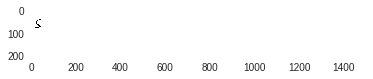

  5 -> 5


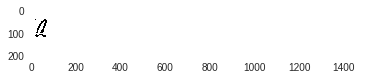

  A -> A


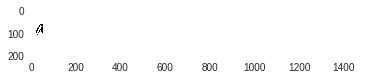

  a -> a
  Batch: 30 Loss: 3.0426718990008035
TF: True


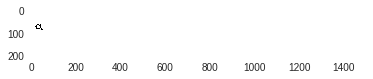

  a -> a


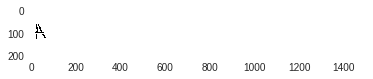

  A -> A


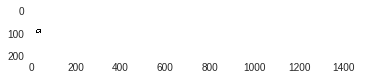

  a -> a
  Batch: 60 Loss: 1.4376016716162363
TF: True


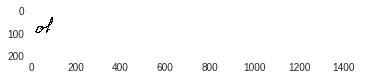

  of -> of


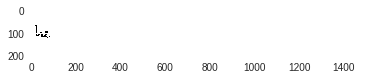

  he -> he


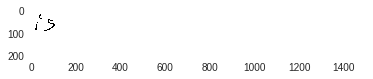

  is -> is
  Batch: 90 Loss: 3.4732501029968263
TF: True


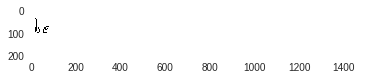

  be -> be


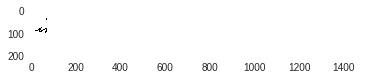

  is -> is


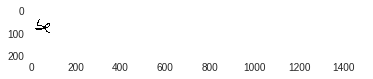

  be -> be
  Batch: 120 Loss: 5.01739178498586
TF: True


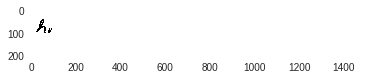

  he -> he


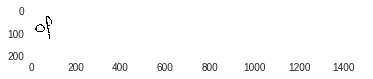

  of -> of


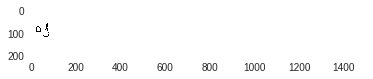

  of -> of
  Batch: 150 Loss: 3.011827325820923


KeyboardInterrupt: ignored

In [0]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-4, weight_decay=0.00005)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=0.00005)

criterion = nn.NLLLoss()

teacher_forcing_ratio = 1#0.5

from random import random


def train(epoch):
  print("Training epoch " + str(epoch) + "...")
  
  freq = 30
  
  train_set.to_start()
  batch_idx = 0
  c_loss = 0
  START = train_set.start_code
  STOP = train_set.stop_code
  current_symbol = torch.LongTensor(batch_size, 30+1).to(device)
  stop_symbol = torch.LongTensor(batch_size, 1).to(device)
  stop_symbol.fill_(STOP)
  
  
  
  while True:
    batch = train_set.make_batch()
    if batch is None:
      break
    encoder.zero_grad()
    decoder.zero_grad()
    
    orig_data, target = batch
    if target.shape[1] > 4:
      break
    data = orig_data/255.0
    data = data.view(batch_size, 1, image_width, image_height).to(device)
    target = target.to(device)
    hidden = decoder.makeHidden()    

    loss = 0
    enc = encoder(data)
    #print(enc.shape)
    s = enc.permute(1, 0, 2)
    #print(s.shape)
    s = s.flatten(start_dim=1).view(1, batch_size, -1)
    
    current_symbol[:, 0] = START
    use_teacher_forcing = True if random() < teacher_forcing_ratio else False

    for i in range(0, target.shape[1]):

      symb = current_symbol[:, i].view(batch_size, 1).contiguous()
        
      dec, hidden = decoder(s, symb, hidden)
      
      if False:#(batch_idx % freq == 0) and (batch_idx != 0):
        if i == 0:
          print("------------")
        if i in [0, 3, 7]:
          im = decoder.attention_weights[0,0,:].cpu().detach().numpy()
          print(im.shape)
          plt.plot(im)
          plt.show()
      if i == target.shape[1]:
        t = stop_symbol.flatten()
      else:
        t = target[:, i].flatten()
      if use_teacher_forcing:
        current_symbol[:, i + 1] = t#target[:, i]
      else:
        sampled = torch.multinomial(dec.exp(), 1)
        current_symbol[:, i+1] = sampled.squeeze()
      o = dec
      loss += criterion(o, t)
    c_loss += loss.item()/(target.shape[1] + 0)
    if (batch_idx % freq == 0) and (batch_idx != 0):
      print("TF: " + str(use_teacher_forcing))
      if True:#not use_teacher_forcing:
        for k in range(0, min(3, target.shape[0])):
            decoded = current_symbol[k,1:target.shape[1]+1]
            plt.imshow(orig_data[k].cpu(), cmap="gray")
            plt.show()
            print("  " + train_set.decode_word(target[k,:]) + " -> " + train_set.decode_word(decoded))
      c_loss /= freq 
      print("  Batch: " + str(batch_idx) + " Loss: " + str(c_loss))
      c_loss = 0
    loss.backward()
    grad_clip = 0.1
    torch.nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    torch.nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    batch_idx += 1

for i in range(0, 100):
  train(i)
